##  Imports and Setup

In [1]:
from parse_circuit import parse_circuit


In [2]:
import os
import warnings
from os import path

# Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

# Path to data directory
DATA_PATH = "./grape"

# Set the working directory
os.chdir(DATA_PATH)

import grape  # Grammatical evolution library

# Path to grammar file
GRAMMAR_FILE = "grover.bnf"
BNF_GRAMMAR_PATH = path.join("grammars", GRAMMAR_FILE)
BNF_GRAMMAR = grape.Grammar(BNF_GRAMMAR_PATH)
import algorithms  # Evolutionary algorithms


In [3]:
from qiskit import QuantumCircuit, transpile  # Core Qiskit imports
from qiskit_aer import QasmSimulator  # Simulator
from qiskit.visualization import plot_histogram  # Plotting results
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from deap import creator, base, tools  # Genetic Algorithm tools

## Define Oracle and Reflection Operators

In [4]:
# Define the oracle dynamically for the marked state
def create_oracle(marked_state):
    n = len(marked_state)
    oracle = QuantumCircuit(n, name='oracle')
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    oracle.h(n - 1)
    oracle.mcx(list(range(n - 1)), n - 1)
    oracle.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    return oracle.to_gate()

In [5]:
# Define the Grover reflection operator
def create_reflection(n):
    reflection = QuantumCircuit(n, name='reflection')
    reflection.h(range(n))
    reflection.x(range(n))
    reflection.h(n - 1)
    reflection.mcx(list(range(n - 1)), n - 1)
    reflection.h(n - 1)
    reflection.x(range(n))
    reflection.h(range(n))
    return reflection.to_gate()

In [6]:
# Define the Grover's circuit with a specific marked state
def grover_circuit(marked_state):
    """
    Creates the full Grover circuit for a given marked state.
    """
    n = len(marked_state)  # Number of qubits required
    grover_circ = QuantumCircuit(n, n)  # Classical bits = qubits for measurement
    grover_circ.h(range(n))  # Apply Hadamard gates to all qubits

    # Add the oracle and reflection gates
    oracle_gate = create_oracle(marked_state)
    reflection_gate = create_reflection(n)

    # Repeat Grover iterations
    num_iterations = int(np.round(np.sqrt(2 ** n)))  # Optimal number of iterations
    for _ in range(num_iterations):
        grover_circ.append(oracle_gate, range(n))
        grover_circ.append(reflection_gate, range(n))

    # Measure all qubits
    grover_circ.measure(range(n), range(n))
    return grover_circ

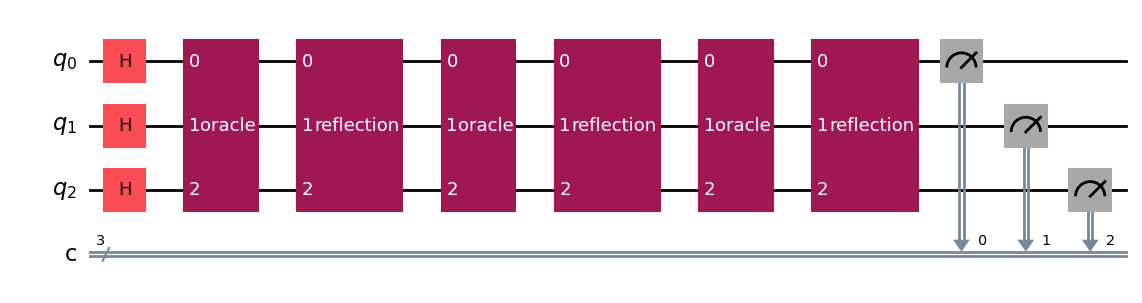

In [7]:
# Test Grover's circuit with a specific marked state
marked_state = '001'  # Specify the marked state
grover_circ = grover_circuit(marked_state)
grover_circ.draw('mpl')


In [8]:
# Simulate the Grover circuit
simulator = QasmSimulator()
compiled_circuit = transpile(grover_circ, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

In [9]:
# Get the measurement counts (bitstring outcomes)
counts = result.get_counts()
corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
print(corrected_counts)



{'101': 94, '110': 100, '111': 102, '010': 110, '000': 95, '100': 110, '011': 105, '001': 308}


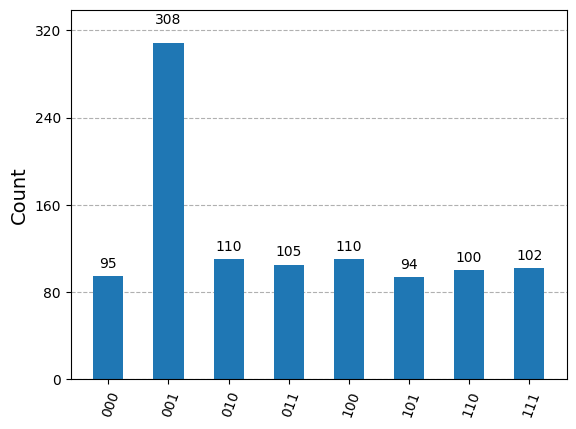

In [10]:
# Plot the results
display(plot_histogram(corrected_counts))

# Grammatical Evolution

## Fitness Function

In [11]:
def fitness_function(circuit: QuantumCircuit, 
                     marked_state: str = '000', 
                     shots: int = 1024) -> float:
    """
    A lexicographic fitness function inspired by the approach in certain GP/Grover references.
    
    Lower returned values => better performance.
    We combine "number of misses" and "probability of error" in a single metric:
        - M = shots - counts[marked_state]
        - PE = 1 - (counts[marked_state] / shots)
        - If M = 0, cost = 0.1 * PE
        - Otherwise, cost = 10*M + PE
    """
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    
    penalty_value = 1e6  # Large cost if something goes wrong.
    
    try:
        # Run the circuit and get the resulting counts
        result = simulator.run(compiled_circuit, shots=shots).result()
        counts = result.get_counts(compiled_circuit)
        
        # Probability of measuring each state
        total_shots = sum(counts.values())
        
        # Gracefully handle if the marked_state is missing
        marked_count = counts.get(marked_state, 0)
        
        # Calculate "misses" and "probability of error"
        M = shots - marked_count
        PE = 1.0 - (marked_count / shots)
        
        # Lexicographic combination
        if M == 0:
            # Optional special weighting if we have zero integer misses
            fitness = 0.1 * PE
        else:
            fitness = 10.0 * M + PE

    except Exception as e:
        print(f"[Simulation Error] {e}")
        print(circuit.draw('mpl'))
        fitness = penalty_value
    
    return fitness

## Decode Individual

In [12]:
import re


def decode_individual(ind):
    """
    Decodes the individual's genome into a quantum circuit.
    Returns:
        A QuantumCircuit object if decoding is successful,
        or None if invalid.
    """
    if ind.invalid or not hasattr(ind, 'phenotype'):
        return None

    try:
        # Ensure the phenotype is a single string
        phenotype_code = ind.phenotype
        if isinstance(phenotype_code, list):
            phenotype_code = "".join(phenotype_code)

        # Clean the phenotype using regex
        cleaned_code = re.sub(r'\\n', '\n', phenotype_code)  # Replace literal \n with newlines
        cleaned_code = re.sub(r'^"|"$', '', cleaned_code)       # Remove leading/trailing quotes
        cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)      # Replace isolated quotes with newlines

        # Use the parse_circuit function to get the QuantumCircuit
        qc = parse_circuit(cleaned_code)
        return qc

    except Exception as ex:
        print(f"[Decode Error] {ex}")
        return None


##  GE Initialization

In [13]:
POPULATION_SIZE = 100 
MAX_GENERATIONS = 5   
P_CROSSOVER = 0.45      
P_MUTATION = 0.45      
ELITE_SIZE = 1          
HALLOFFAME_SIZE = 1     
CODON_SIZE = 400       
MAX_TREE_DEPTH = 500     
TOURNAMENT_SIZE = 5     

In [14]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=20,  
    max_init_depth=20,  
    codon_size=255,
    codon_consumption="lazy",
    genome_representation="list"
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)


## Evaluate Function

In [15]:
from typing import Any, Tuple


def evaluate(individual: Any, marked_state: str = '000') -> Tuple[float]:
    """
    Evaluate an individual by decoding its phenotype into a quantum circuit and computing its fitness.
    
    Parameters:
        individual: The encoded individual representation from your evolutionary algorithm.
        marked_state (str): The target state that Grover's algorithm should ideally amplify.
        
    Returns:
        Tuple[float]: A tuple containing the fitness score. If decoding fails, returns (infinity,).
    """
    try:
        qc = decode_individual(individual)
    except Exception as e:
        print(f"[Decoding Error] {e}")
        return (float('inf'),)
    
    if qc is None:
        # Return a neutral (worst) fitness if decoding fails.
        return (float('inf'),)
    
    fitness_val = fitness_function(qc, marked_state=marked_state)
    return (fitness_val,)


toolbox.register("evaluate", evaluate)


In [16]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GE evolutionary algorithm with elitism
population, logbook = algorithms.ge_eaSimpleWithElitism(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    codon_size=255,
    max_tree_depth=500,
    max_genome_length=None,
    codon_consumption="eager",
    report_items=["gen", "min", "max", "avg", "std"],
    genome_representation="list",
    stats=stats,
    halloffame=hof,
    verbose=True
)

gen	invalid	avg  	std	min  	max  	best_ind_length	avg_length	best_ind_nodes	avg_nodes	best_ind_depth	avg_depth	avg_used_codons	best_ind_used_codons	behavioural_diversity	structural_diversity	fitness_diversity	selection_time	generation_time
0  	0      	10241	0  	10241	10241	19             	132.31    	7             	35.3     	11            	16.2     	88.38          	13                  	0                    	1                   	0                	0             	3.84459        
1  	30     	inf  	nan	10241	inf  	19             	167.729   	7             	14.6429  	11            	13.3286  	49             	13                  	0                    	0.7                 	0                	0.00022006    	2.4297         
2  	12     	inf  	nan	10241	inf  	19             	161.977   	7             	12.5682  	11            	12.5455  	41.3864        	13                  	0                    	0.88                	0                	0.000231028   	3.07395        
3  	9      	inf  	nan	10241	inf  	19    


[HALL OF FAME]
Individual 1:
Genome: [168, 202, 117, 93, 154, 155, 19, 97, 192, 251, 107, 20, 0, 86, 113, 232, 109, 137, 88]
Phenotype: "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Oracle\n" "qc.swap(" "1,2" ")\n" "## End Oracle\n" "## Begin Diffuser\n" "qc.cx(0,2)\n" "qc.cy(" "2,1" ")\n" "qc.h(0)\n" "## End Diffuser\n" "qc.measure(0, 0)\n" "qc.measure(1, 1)\n" "qc.measure(2, 2)\n"
Fitness: 10241.0


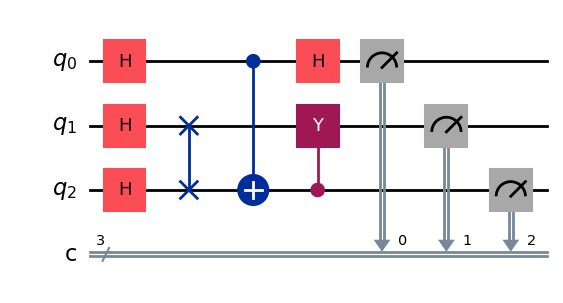


Best Individual's Fitness: 10241.0


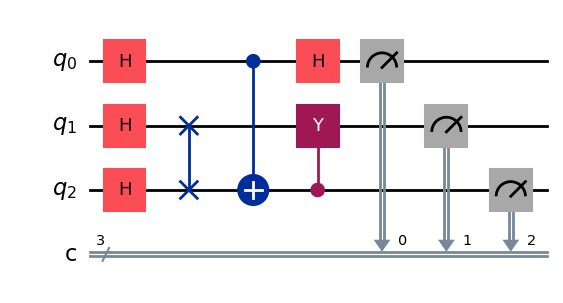


Final Measurement Counts: {'010': 248, '000': 250, '011': 259, '001': 267}


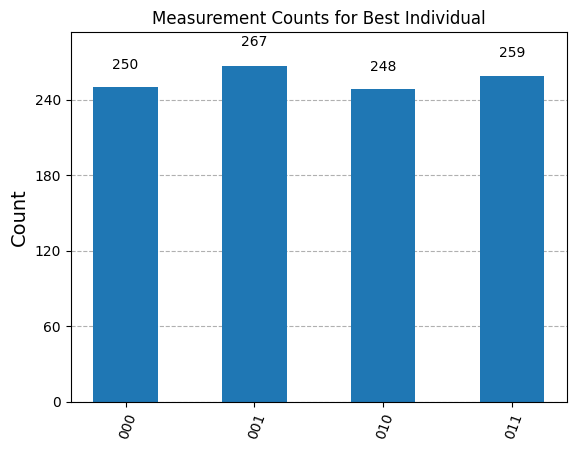

In [17]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode and display the best circuit from the Hall of Fame
best_ind = hof.items[0]
best_circuit = decode_individual(best_ind)
if best_circuit:
    # print("\n[Best Individual's Circuit]")
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")

# %%
print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

best_circuit = decode_individual(best_ind)
if best_circuit:
    display(best_circuit.draw('mpl'))
    simulator = QasmSimulator()
    compiled_circuit = transpile(best_circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()
    corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
    print("\nFinal Measurement Counts:", corrected_counts)
    display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))
else:
    print("Best individual could not be decoded into a valid circuit.")


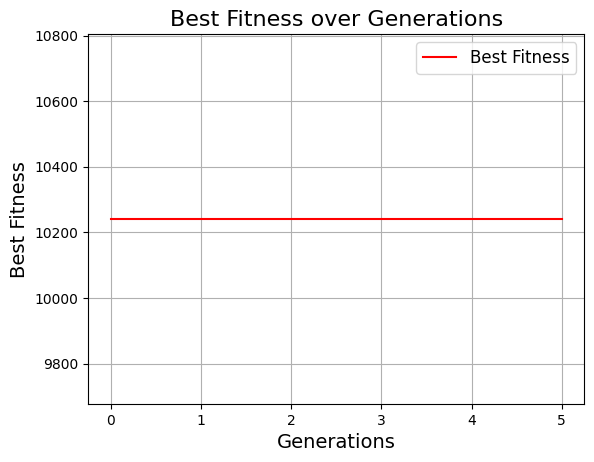

In [18]:
# Extract generations and minimum fitness values
generations = logbook.select("gen")
min_fitness_values = logbook.select("min")

# Plot best fitness over generations
plt.plot(generations, min_fitness_values, color='red', label="Best Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.grid(True)
plt.show()